# Finding Dory
## Politecnico di Milano, Internet of Things + Wireless Internet project
### Processing and localization

In the fist part of this project we have collected from the CoAP and MQTT server a total of 180 fingerprints and Dory's RSSI. In this part of the project we analyze the data and localize Dory using fingerprint-based methods.


# Import data

The fist step is importing the retrieved data and set it up in a format suitable for analysis. In this section we import the data by parsing with simple custom parsers the hand-crafted text files and convert the entire dataset into a standard dataframe, suitable for further analysis.

In [79]:
import ast
import pandas as pd
import numpy as np
from numpy.ma.core import log10

## Import data from CoAP

In [80]:
data_coap = []
with open("coap/coap_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("||")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integet literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(ast.literal_eval , ast.literal_eval(anchor_readings.strip()))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:]
      for anchor_idx in range(len(anchors_readings)):
        #print(anchors_readings[anchor_idx])
        row.append(anchors_readings[anchor_idx][exp_idx])
      data_coap.append(row)
  
  # build df
  df_coap = pd.DataFrame(data=data_coap, columns=["X", "Y", "A1", "A2", "A3", "A4", "A5", "A6"])
  display(df_coap)

,X,Y,A1,A2,A3,A4,A5,A6
0,10,6,-64,-64,-61,-59,-59,-55
1,10,6,-60,-60,-57,-55,-55,-51
2,10,6,-62,-61,-58,-56,-57,-53
3,10,6,-66,-66,-63,-61,-61,-57
4,10,6,-64,-64,-61,-59,-59,-55
...,...,...,...,...,...,...,...,...
105,8,2,-62,-64,-55,-52,-62,-62
106,8,2,-68,-70,-61,-58,-68,-69
107,8,2,-64,-67,-57,-55,-64,-64
108,8,2,-70,-72,-63,-60,-70,-70


## Import data from MQTT

In [81]:
data_mqtt = []
with open("mqtt/mqtt_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("|")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integet literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(int , anchor_readings.strip().split(","))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:]
      for anchor_idx in range(len(anchors_readings)):
        #print(anchors_readings[anchor_idx])
        row.append(anchors_readings[anchor_idx][exp_idx])
      data_mqtt.append(row)
  
  # build df
  df_mqtt = pd.DataFrame(data=data_mqtt, columns=["X", "Y", "A1", "A2", "A3", "A4", "A5", "A6"])
  display(df_mqtt)

,X,Y,A1,A2,A3,A4,A5,A6
0,4,6,-63,-61,-62,-65,-59,-63
1,4,6,-62,-60,-60,-63,-57,-62
2,4,6,-63,-61,-62,-65,-59,-63
3,4,6,-62,-65,-61,-63,-57,-62
4,4,6,-63,-61,-61,-64,-58,-63
...,...,...,...,...,...,...,...,...
65,8,4,-59,-61,-54,-55,-57,-56
66,8,4,-66,-67,-61,-60,-63,-63
67,8,4,-64,-65,-59,-58,-61,-61
68,8,4,-65,-66,-60,-59,-62,-62


## Merging the two data sets plus Dory's RSSI

In [82]:
df = pd.concat([df_coap, df_mqtt])

# manually define Dory's RSSI
Dory_RSSI = [-57,-63,-58,-64,-63,-66]
Dory_RSSI_np = np.array(Dory_RSSI)
Dory_RSSI_mw = np.power(10, Dory_RSSI_np/10)

# dataset constraints to check if the data is valid
assert(len(df) == 6*6*5)
assert(df.isna().sum().sum() == 0)


display(df)

,X,Y,A1,A2,A3,A4,A5,A6
0,10,6,-64,-64,-61,-59,-59,-55
1,10,6,-60,-60,-57,-55,-55,-51
2,10,6,-62,-61,-58,-56,-57,-53
3,10,6,-66,-66,-63,-61,-61,-57
4,10,6,-64,-64,-61,-59,-59,-55
...,...,...,...,...,...,...,...,...
65,8,4,-59,-61,-54,-55,-57,-56
66,8,4,-66,-67,-61,-60,-63,-63
67,8,4,-64,-65,-59,-58,-61,-61
68,8,4,-65,-66,-60,-59,-62,-62


In [83]:
np.array(log10(Dory_RSSI_mw)*10)

array([-57., -63., -58., -64., -63., -66.])

## Minimum Euclidean Distance
Now we can compute the euclidean distance of each figerprint from the sample:

In [84]:
def compute_euclidean_distance(row):
  return np.linalg.norm(Dory_RSSI_np - row[["A1", "A2", "A3", "A4", "A5", "A6"]])

def compute_euclidean_distance_mw(row):
  return np.linalg.norm(Dory_RSSI_mw - np.power(10, row[["A1", "A2", "A3", "A4", "A5", "A6"]] / 10))

df['Euclidean Distance'] = df.apply(compute_euclidean_distance, axis=1)
df['Euclidean Distance Milliwatt'] = df.apply(compute_euclidean_distance_mw, axis=1)

And we can print the fingeprints and their Euclidean distance values to check which is the closest to Dory, for both types of distance metrics.

In [85]:
display(df.nsmallest(20, 'Euclidean Distance', 'all').loc[:,df.columns!="Euclidean Distance Milliwatt"])

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance
48,2,4,-58,-61,-59,-64,-62,-65,2.828427
47,2,4,-58,-61,-59,-64,-61,-65,3.316625
85,2,2,-54,-63,-56,-63,-64,-66,3.872983
53,0,4,-57,-61,-61,-66,-63,-66,4.123106
87,2,2,-54,-61,-56,-63,-63,-65,4.358899
21,4,4,-61,-62,-57,-62,-61,-64,5.477226
54,0,4,-58,-62,-62,-67,-64,-68,5.656854
89,2,2,-53,-62,-55,-62,-62,-65,5.656854
33,4,2,-58,-64,-53,-61,-63,-65,6.082763
34,4,2,-59,-65,-53,-62,-64,-66,6.164414


In [86]:
display(df.nsmallest(20, 'Euclidean Distance Milliwatt', 'all').loc[:,df.columns!="Euclidean Distance"])

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance Milliwatt
48,2,4,-58,-61,-59,-64,-62,-65,6.177862e-07
47,2,4,-58,-61,-59,-64,-61,-65,6.713801e-07
53,0,4,-57,-61,-61,-66,-63,-66,8.558678e-07
29,2,0,-57,-71,-60,-69,-71,-73,9.013232e-07
54,0,4,-58,-62,-62,-67,-64,-68,1.074193e-06
86,2,2,-59,-69,-61,-64,-69,-71,1.215885e-06
25,2,0,-55,-69,-58,-67,-69,-71,1.308645e-06
21,4,4,-61,-62,-57,-62,-61,-64,1.337618e-06
10,6,4,-63,-64,-58,-62,-62,-65,1.522556e-06
46,2,4,-61,-64,-62,-67,-65,-68,1.563681e-06


## Aggregating data and dealing with missing values
Let us average all readings for an anchor at a position and build a dataframe of mean readings.

In [87]:
means_data = []
for x in range(0,11,2):
    for y in range(0,11,2):
      row = [x,y]
      row += df.loc[(df['X'] == x) & (df['Y'] == y)].mean()[["A1", "A2","A3","A4","A5","A6"]].values.tolist()
      means_data.append(row)
df_means = pd.DataFrame(data=means_data, columns=['X', 'Y', "A1", "A2", "A3", "A4", "A5", "A6"])
display(df_means)

,X,Y,A1,A2,A3,A4,A5,A6
0,0,0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0,2,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0,4,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0,6,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0,8,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
5,0,10,-66.0,-23.6,-65.2,-67.0,-58.0,-64.0
6,2,0,-52.6,-66.6,-56.0,-65.0,-66.8,-68.6
7,2,2,-54.4,-63.2,-56.4,-62.6,-63.8,-66.2
8,2,4,-58.2,-61.2,-59.2,-64.2,-61.8,-65.2
9,2,6,-62.0,-59.2,-61.6,-65.6,-60.0,-64.8


### Interpolations
Let us now perform linear and bilinear interpolation as needed to fill in the missing values

In [88]:
# row-based
df_interpolation = df_means.copy()
for x in range(1,10,2):
  for y in range(0,11,2):
    #print((x,y), (x-1, y), (x+1, y))
    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['X'] == (x - 1)) |
                                       (df_interpolation['X'] == (x + 1))) &
                                       (df_interpolation['Y'] == y)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])
    #df[x,y] = df[]

# column-based
for x in range(0,11,1):
  for y in range(1,10,1):
    #print((x,y), (x, y-1), (x, y+1))
    if not df_interpolation.loc[(df_interpolation['X'] == x) &
                                (df_interpolation['Y'] == y)].empty:
      continue
    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['Y'] == (y - 1)) |
                                       (df_interpolation['Y'] == (y + 1))) &
                                       (df_interpolation['X'] == x)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])

display(df_interpolation)

,X,Y,A1,A2,A3,A4,A5,A6
0,0.0,0.0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0.0,2.0,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0.0,4.0,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0.0,6.0,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0.0,8.0,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
...,...,...,...,...,...,...,...,...
0,10.0,1.0,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5
0,10.0,3.0,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8
0,10.0,5.0,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0
0,10.0,7.0,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6


In [93]:
df_interpolation['Euclidean Distance'] = df_interpolation.apply(compute_euclidean_distance, axis=1)
df_interpolation['Euclidean Distance Milliwatt'] = df_interpolation.apply(compute_euclidean_distance_mw, axis=1)
display(df_interpolation.nsmallest(20, 'Euclidean Distance', 'all').loc[:,df.columns!="Euclidean Distance Milliwatt"])
display(df.nsmallest(20, 'Euclidean Distance Milliwatt', 'all').loc[:,df.columns!="Euclidean Distance"])

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance
0,2.0,3.0,-56.30,-62.20,-57.80,-63.40,-62.80,-65.70,1.288410
0,3.0,3.0,-58.60,-63.35,-57.05,-63.20,-63.10,-65.70,2.079663
0,1.0,3.0,-55.20,-62.00,-59.00,-64.40,-63.15,-66.20,2.337199
8,2.0,4.0,-58.20,-61.20,-59.20,-64.20,-61.80,-65.20,2.870540
0,1.0,4.0,-57.50,-60.80,-59.90,-64.80,-62.10,-65.60,3.210919
7,2.0,2.0,-54.40,-63.20,-56.40,-62.60,-63.80,-66.20,3.464102
0,3.0,2.0,-57.20,-64.60,-55.40,-62.80,-64.40,-66.60,3.622154
0,3.0,4.0,-60.00,-62.10,-58.70,-63.60,-61.80,-64.80,3.652396
2,0.0,4.0,-56.80,-60.40,-60.60,-65.40,-62.40,-66.00,3.984972
0,0.0,3.0,-54.10,-61.80,-60.20,-65.40,-63.50,-66.70,4.170132


,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance Milliwatt
48,2,4,-58,-61,-59,-64,-62,-65,6.177862e-07
47,2,4,-58,-61,-59,-64,-61,-65,6.713801e-07
53,0,4,-57,-61,-61,-66,-63,-66,8.558678e-07
29,2,0,-57,-71,-60,-69,-71,-73,9.013232e-07
54,0,4,-58,-62,-62,-67,-64,-68,1.074193e-06
86,2,2,-59,-69,-61,-64,-69,-71,1.215885e-06
25,2,0,-55,-69,-58,-67,-69,-71,1.308645e-06
21,4,4,-61,-62,-57,-62,-61,-64,1.337618e-06
10,6,4,-63,-64,-58,-62,-62,-65,1.522556e-06
46,2,4,-61,-64,-62,-67,-65,-68,1.563681e-06


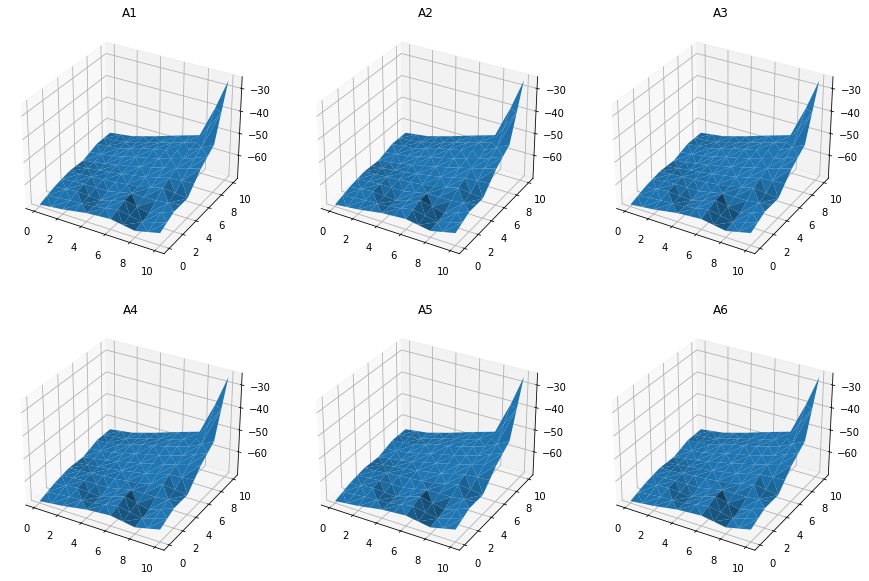

In [90]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))

for idx, station in enumerate(["A1","A2","A3","A4","A5","A6",]):
  data = df_interpolation[["X","Y",station]].values
  x = data[:,0]
  y = data[:,1]
  Z = data[:,2]  
  ax = fig.add_subplot(2,3,(idx%6)+ 1, projection='3d')
  ax.set_title(station)
  ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True) #plot_surface(X, Y, Z)